In [1]:
#library
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
#data
from sklearn import datasets

mnist = datasets.fetch_mldata('MNIST original', data_home=".")
n = len(mnist.data)
N = 24000
indices = np.random.permutation(range(n))[:N]
X = mnist.data[indices]
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]

In [3]:
#train/test/validation
N_train = 20000
N_validation = 4000

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=N_train, random_state=0)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation, random_state=0)

In [4]:
class DNN(object):
    
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_in = n_in
        self.n_hiddens = n_hiddens
        self.n_out = n_out
        
        self.weights = []
        self.biases = []
        
        self._x = None
        self._t = None
        self._keep_prob = None
        self._sess = None
        
        self._history ={
            'accuracy': [],
            'loss': []
        }
        
    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)
    
    def inference(self, x, keep_prob):   
        for i, n_hidden in enumerate(self.n_hiddens):
            if i==0:
                input = x
                input_dim = self.n_in
            else:
                input = output
                input_dim = self.n_hiddens[i-1]
            
            W = self.weight_variable([input_dim,n_hidden])
            b = self.bias_variable([n_hidden])
            self.weights.append(W)
            self.biases.append(b)
        
            h = tf.nn.sigmoid( tf.matmul(input,W) + b )
            output = tf.nn.dropout(h, keep_prob)
        
        W_out = self.weight_variable([self.n_hiddens[-1],self.n_out])
        b_out = self.bias_variable([self.n_out]) 
        self.weights.append(W_out)
        self.biases.append(b_out)
        
        y = tf.nn.softmax( tf.matmul(output,W_out) + b_out ) 
        return y
    
    def loss(self, y, t):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(t*tf.log(y),reduction_indices=[1]))
        return cross_entropy
    
    def training(self, loss):
        optimizer = tf.train.GradientDescentOptimizer(0.1)
        train_step = optimizer.minimize(loss)
        return train_step
    
    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(t,1))
        accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )
        return accuracy
    
    def fit(self, X_train, Y_train, X_validationi, Y_validation, epochs=100, batch_size=100, p_keep=0.5, verbose=1):
        n_batches = N // batch_size
        
        x = tf.placeholder(tf.float32, shape=[None,self.n_in])
        t = tf.placeholder(tf.float32, shape=[None,self.n_out])
        keep_prob = tf.placeholder(tf.float32)
        
        y = self.inference(x, keep_prob)
            
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)

        self._x = x
        self._t = t
        self._keep_prob = keep_prob
        self._sess = sess
        
        self._accuracy = accuracy = self.accuracy(y, t)
        
        loss = self.loss(y,t)
        train_step = self.training(loss)
        
        for epoch in range(epochs):
            X_, Y_ = shuffle(X_train, Y_train, random_state=0)
            #print(epoch)
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
            
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_validation, t: Y_validation, keep_prob: 1.0
            })
            accuracy_ = accuracy.eval(session=sess, feed_dict={
                x: X_validation, t: Y_validation, keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)
            if verbose and epoch % 10 == 0:
                print("epoch=%d, accuracy=%g" % (epoch, accuracy_))
                      
        return self._history
                
    def evaluate(self, X_test, Y_test):
        return self._accuracy.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })

In [5]:
epochs = 500
model = DNN( len(X[0]), [100,100], len(Y[0]) )
history = model.fit(X_train, Y_train, X_validation, Y_validation, epochs=epochs, batch_size=100, p_keep=0.5)
accuracy = model.evaluate(X_test, Y_test)
print('accuracy:', accuracy)

epoch=0, accuracy=0.22625
epoch=10, accuracy=0.74825
epoch=20, accuracy=0.8255
epoch=30, accuracy=0.851
epoch=40, accuracy=0.874
epoch=50, accuracy=0.88325
epoch=60, accuracy=0.8745
epoch=70, accuracy=0.89275
epoch=80, accuracy=0.88725
epoch=90, accuracy=0.89225
epoch=100, accuracy=0.8915
epoch=110, accuracy=0.89475
epoch=120, accuracy=0.89625
epoch=130, accuracy=0.902
epoch=140, accuracy=0.9015
epoch=150, accuracy=0.908
epoch=160, accuracy=0.91
epoch=170, accuracy=0.90325
epoch=180, accuracy=0.912
epoch=190, accuracy=0.90225
epoch=200, accuracy=0.90875
epoch=210, accuracy=0.91325
epoch=220, accuracy=0.91475
epoch=230, accuracy=0.9085
epoch=240, accuracy=0.92025
epoch=250, accuracy=0.91375
epoch=260, accuracy=0.91475
epoch=270, accuracy=0.913
epoch=280, accuracy=0.914
epoch=290, accuracy=0.91475
epoch=300, accuracy=0.915
epoch=310, accuracy=0.92525
epoch=320, accuracy=0.92075
epoch=330, accuracy=0.92
epoch=340, accuracy=0.9215
epoch=350, accuracy=0.92075
epoch=360, accuracy=0.921
epoch

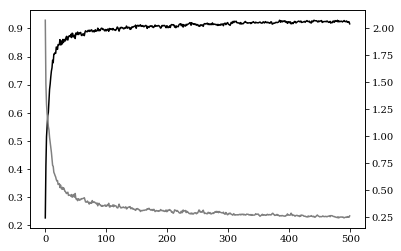

In [6]:
plt.rc('font', family="serif")
fig = plt.figure()

ax_acc = fig.add_subplot(111)
ax_acc.plot(range(epochs),history['accuracy'], label='acc', color='black')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epochs),history['loss'], label='loss', color='gray')

plt.xlabel('epochs')

plt.show()